In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

file_path = './Synched_Data_GR0_22_DEN_MAXZ1_25/'
file_date = ['101922', '102122', '111422', '111622', '120522', '120722', '013023', '020123', '031323', '031523', '041723', '041923', '061523']

In [2]:
# Load data and return the processed DataFrame
def process_input_data(file_date_str):
    file_name = f'COTALK/DAYCOTALK_TYPE_{file_date_str}_COTALK0_22_DEN_012325_V2264433238.csv'
    full_path = file_path + file_name
    
    header_co = pd.read_csv(full_path)
    read_co = header_co[["SUBJECTID", "TIME", "KC_X", "KC_Y"]]
    read_co.to_csv(f'Synched_Data_GR0_22_DEN_MAXZ1_25/COTALK/co_{file_date_str}.txt', header=False, index=False)
    
    co = pd.read_csv(f'Synched_Data_GR0_22_DEN_MAXZ1_25/COTALK/co_{file_date_str}.txt', 
                    header=None, names=["SUBJECTID", "TIME", "KC_X", "KC_Y"])
    co["TIME"] = pd.to_datetime(co["TIME"])
    co.set_index("TIME", inplace=True)
    
    return co

In [3]:
# Resample the data in second and minute scale
def resample_data(co_data, file_date_str, time_scale='1s', output_dir='sec'):
    resample_freq = '1s' if time_scale == 'sec' else '1min'
    
    resampled_co = co_data.groupby("SUBJECTID").resample(resample_freq).first().dropna()
    resampled_co['Formatted_TIME'] = resampled_co.index.get_level_values('TIME').strftime('%H:%M:%S')
    
    resampled_co.to_csv(f'data_resample/{output_dir}/csv/co_{file_date_str}_resampled.csv', header=False, index=False)
    resampled_co.to_csv(f'data_resample/{output_dir}/txt/co_{file_date_str}_resampled.txt', header=False, index=False)
    
    return resampled_co

In [4]:
def find_time_gaps(group, threshold):
    group = group.sort_values("Formatted_TIME")
    time_diff = group["Formatted_TIME"].diff()
    
    # Identify time gaps
    gap_indices = time_diff > threshold
    gaps = group["Formatted_TIME"][gap_indices]
    previous_times = group["Formatted_TIME"].shift(1)[gap_indices]  # When the gap starts
    
    if not gaps.empty:
        gap_pairs = [f"{prev.strftime('%H:%M:%S')} → {gap.strftime('%H:%M:%S')}" 
                     for prev, gap in zip(previous_times, gaps)]
        return f"time gap: {len(gaps)} from {', '.join(gap_pairs)}"
    return "No time gaps"

In [5]:
def check_discontinuity(file_date_str, time_scale='min'):
    threshold = pd.Timedelta(minutes=1) if time_scale == 'min' else pd.Timedelta(seconds=1)
    
    file_name = f"co_{file_date_str}_resampled.csv"
    file_path = f"data_resample/{time_scale}/csv/{file_name}"
    
    resampled_data = pd.read_csv(file_path, header=None, names=["SUBJECTID", "KC_X", "KC_Y", "Formatted_TIME"])
    resampled_data["Formatted_TIME"] = pd.to_datetime(resampled_data["Formatted_TIME"], format='%H:%M:%S', errors='coerce')

    gap_results = resampled_data.groupby("SUBJECTID").apply(lambda x: find_time_gaps(x, threshold))

    print(f"\nIn the file {file_name}:")
    for subject_id, gaps in gap_results.items():
        print(f" {subject_id}   {gaps}")
    
    return resampled_data

In [6]:
def segment_time_periods(group, threshold):
    group = group.sort_values("Formatted_TIME")
    time_diff = group["Formatted_TIME"].diff()

    gap_indices = time_diff > threshold
    segment_ids = gap_indices.cumsum()  # Add a segment ID

    # Collect segments
    segments = {}
    for segment_id, segment_data in group.groupby(segment_ids):
        start_time = segment_data["Formatted_TIME"].iloc[0].strftime('%H:%M:%S')
        end_time = segment_data["Formatted_TIME"].iloc[-1].strftime('%H:%M:%S')
        segments[segment_id] = f"{start_time} → {end_time}"

    return segments

In [14]:
def find_inaccurate_data(group):
    group = group.sort_values("Formatted_TIME")

    # Distance
    x1, x2 = group["KC_X"], group["KC_X"].shift(-1)
    y1, y2 = group["KC_Y"], group["KC_Y"].shift(-1)
    distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    # Set threshold
    inaccurate_indices = distance > 1.5
    inaccurate_times = group["Formatted_TIME"][inaccurate_indices]

    if not inaccurate_times.empty:
        return f"inaccurate data: {len(inaccurate_times)} at {', '.join(inaccurate_times.dt.strftime('%H:%M:%S'))}"
    return "No inaccurate data"

In [8]:
# Process and resample all files
for i in range(len(file_date)):
    co_data = process_input_data(file_date[i])
    
    resampled_sec = resample_data(co_data, file_date[i], time_scale='sec', output_dir='sec')
    resampled_min = resample_data(co_data, file_date[i], time_scale='min', output_dir='min')
    
    print(f'Number length in co_{file_date[i]}.txt: {len(co_data)}')
    print(f'Number length in co_{file_date[i]}_resampled in second scale: {len(resampled_sec)}')
    print(f'Number length in co_{file_date[i]}_resampled in minute scale: {len(resampled_min)}')

Number length in co_101922.txt: 983052
Number length in co_101922_resampled in second scale: 98343
Number length in co_101922_resampled in minute scale: 1682
Number length in co_102122.txt: 1090302
Number length in co_102122_resampled in second scale: 109070
Number length in co_102122_resampled in minute scale: 1854
Number length in co_111422.txt: 579842
Number length in co_111422_resampled in second scale: 58026
Number length in co_111422_resampled in minute scale: 1004
Number length in co_111622.txt: 1390019
Number length in co_111622_resampled in second scale: 139063
Number length in co_111622_resampled in minute scale: 2378
Number length in co_120522.txt: 1734030
Number length in co_120522_resampled in second scale: 173460
Number length in co_120522_resampled in minute scale: 2953
Number length in co_120722.txt: 1314398
Number length in co_120722_resampled in second scale: 131482
Number length in co_120722_resampled in minute scale: 2231
Number length in co_013023.txt: 1466347
Numb

In [9]:
# Check discontinuity in minute scale
for i in range(len(file_date)):
    check_discontinuity(file_date[i], time_scale='min')


In the file co_101922_resampled.csv:
 DS_STARFISH_2223_27   time gap: 2 from 10:17:00 → 10:19:00, 10:58:00 → 11:43:00
 DS_STARFISH_2223_28   time gap: 3 from 10:58:00 → 11:05:00, 11:06:00 → 11:35:00, 11:35:00 → 11:43:00
 DS_STARFISH_2223_29   time gap: 4 from 10:59:00 → 11:01:00, 11:01:00 → 11:08:00, 11:09:00 → 11:42:00, 11:42:00 → 11:45:00
 DS_STARFISH_2223_31   time gap: 1 from 10:58:00 → 11:42:00
 DS_STARFISH_2223_32   time gap: 2 from 10:59:00 → 11:22:00, 11:22:00 → 11:42:00
 DS_STARFISH_2223_41   time gap: 2 from 10:58:00 → 11:14:00, 11:14:00 → 11:42:00
 DS_STARFISH_2223_42   time gap: 4 from 10:59:00 → 11:06:00, 11:07:00 → 11:28:00, 11:28:00 → 11:41:00, 11:41:00 → 11:43:00
 DS_STARFISH_2223_44   time gap: 1 from 10:59:00 → 11:42:00
 DS_STARFISH_2223_45   time gap: 3 from 10:59:00 → 11:13:00, 11:14:00 → 11:43:00, 11:43:00 → 11:45:00
 DS_STARFISH_2223_46   time gap: 2 from 10:59:00 → 11:04:00, 11:04:00 → 11:46:00
 DS_STARFISH_2223_T10   time gap: 5 from 10:59:00 → 11:07:00, 11:07:

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1141284953.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gap_results = resampled_data.groupby("SUBJECTID").apply(lambda x: find_time_gaps(x, threshold))
/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1141284953.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gap_results = resampled_data.groupby("SUBJECTID").apply(

In [10]:
# Check discontinuity in second scale
for i in range(len(file_date)):
    check_discontinuity(file_date[i], time_scale='sec')

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1141284953.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gap_results = resampled_data.groupby("SUBJECTID").apply(lambda x: find_time_gaps(x, threshold))



In the file co_101922_resampled.csv:
 DS_STARFISH_2223_27   time gap: 3 from 10:17:54 → 10:19:14, 10:25:14 → 10:26:16, 10:58:46 → 11:43:38
 DS_STARFISH_2223_28   time gap: 3 from 10:58:34 → 11:05:28, 11:06:25 → 11:35:10, 11:35:15 → 11:43:08
 DS_STARFISH_2223_29   time gap: 4 from 10:59:15 → 11:01:13, 11:01:26 → 11:08:27, 11:09:10 → 11:42:41, 11:42:43 → 11:45:55
 DS_STARFISH_2223_31   time gap: 2 from 10:58:52 → 11:42:36, 11:43:35 → 11:44:41
 DS_STARFISH_2223_32   time gap: 2 from 10:59:08 → 11:22:27, 11:22:34 → 11:42:37
 DS_STARFISH_2223_41   time gap: 2 from 10:58:34 → 11:14:21, 11:14:25 → 11:42:55
 DS_STARFISH_2223_42   time gap: 5 from 10:59:03 → 11:06:08, 11:07:03 → 11:28:07, 11:28:14 → 11:41:15, 11:41:18 → 11:43:32, 11:44:14 → 11:45:44
 DS_STARFISH_2223_44   time gap: 1 from 10:59:06 → 11:42:52
 DS_STARFISH_2223_45   time gap: 4 from 10:59:12 → 11:13:03, 11:13:08 → 11:14:50, 11:14:50 → 11:43:50, 11:43:51 → 11:45:50
 DS_STARFISH_2223_46   time gap: 2 from 10:59:20 → 11:04:35, 11:0

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1141284953.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gap_results = resampled_data.groupby("SUBJECTID").apply(lambda x: find_time_gaps(x, threshold))
/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1141284953.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gap_results = resampled_data.groupby("SUBJECTID").apply(


In the file co_102122_resampled.csv:
 DS_STARFISH_2223_27   time gap: 3 from 11:00:00 → 11:03:41, 11:03:56 → 11:06:11, 11:06:40 → 11:22:21
 DS_STARFISH_2223_28   time gap: 1 from 10:59:45 → 11:23:37
 DS_STARFISH_2223_29   time gap: 4 from 10:57:35 → 10:59:00, 11:00:18 → 11:15:01, 11:15:57 → 11:18:20, 11:18:33 → 11:24:10
 DS_STARFISH_2223_31   time gap: 3 from 10:59:37 → 11:10:49, 11:10:59 → 11:24:47, 12:42:12 → 12:43:15
 DS_STARFISH_2223_41   time gap: 2 from 11:00:05 → 11:20:26, 11:21:07 → 11:24:02
 DS_STARFISH_2223_42   time gap: 1 from 10:59:43 → 11:23:35
 DS_STARFISH_2223_44   time gap: 2 from 10:59:35 → 11:23:54, 12:38:53 → 12:40:15
 DS_STARFISH_2223_46   time gap: 4 from 10:59:43 → 11:05:54, 11:06:00 → 11:16:10, 11:16:17 → 11:23:45, 12:41:35 → 12:46:32
 DS_STARFISH_2223_T1   time gap: 10 from 09:50:40 → 09:52:18, 11:04:29 → 11:07:54, 11:08:17 → 11:09:19, 11:09:23 → 11:23:27, 11:41:01 → 11:43:11, 11:48:46 → 11:51:26, 12:35:33 → 12:37:07, 12:38:04 → 12:39:31, 12:41:21 → 12:43:49, 

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1141284953.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gap_results = resampled_data.groupby("SUBJECTID").apply(lambda x: find_time_gaps(x, threshold))
/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1141284953.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gap_results = resampled_data.groupby("SUBJECTID").apply(


In the file co_111622_resampled.csv:
 DS_STARFISH_2223_27   time gap: 4 from 11:11:35 → 11:13:15, 11:13:20 → 11:19:27, 11:20:12 → 11:28:27, 12:34:31 → 12:35:59
 DS_STARFISH_2223_29   time gap: 7 from 10:34:59 → 11:01:41, 11:11:35 → 11:22:17, 11:24:21 → 11:26:19, 11:26:22 → 11:27:59, 12:28:42 → 12:29:47, 12:31:07 → 12:32:08, 12:33:59 → 12:35:17
 DS_STARFISH_2223_30   time gap: 3 from 11:10:28 → 11:19:28, 11:20:40 → 11:28:04, 11:28:11 → 11:30:38
 DS_STARFISH_2223_31   time gap: 3 from 11:10:37 → 11:19:45, 11:19:49 → 11:23:52, 11:24:39 → 11:30:27
 DS_STARFISH_2223_32   time gap: 4 from 11:10:37 → 11:12:37, 11:12:52 → 11:26:58, 11:27:07 → 11:28:41, 11:28:49 → 11:30:08
 DS_STARFISH_2223_41   time gap: 5 from 11:11:15 → 11:15:41, 11:16:02 → 11:18:52, 11:20:44 → 11:21:53, 11:22:02 → 11:30:40, 12:30:58 → 12:33:01
 DS_STARFISH_2223_42   time gap: 4 from 11:11:35 → 11:21:57, 11:21:58 → 11:24:08, 11:25:16 → 11:26:26, 12:23:52 → 12:25:27
 DS_STARFISH_2223_43   time gap: 4 from 11:10:32 → 11:15:20

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1141284953.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gap_results = resampled_data.groupby("SUBJECTID").apply(lambda x: find_time_gaps(x, threshold))
/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1141284953.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gap_results = resampled_data.groupby("SUBJECTID").apply(


In the file co_120722_resampled.csv:
 DS_STARFISH_2223_27   time gap: 3 from 10:51:11 → 11:05:17, 11:06:12 → 11:11:24, 11:11:47 → 11:24:55
 DS_STARFISH_2223_28   time gap: 3 from 10:51:16 → 10:56:58, 10:57:07 → 11:18:49, 11:19:48 → 11:26:25
 DS_STARFISH_2223_29   time gap: 4 from 10:51:40 → 10:53:12, 10:53:16 → 11:12:01, 11:12:10 → 11:17:35, 11:17:36 → 11:24:58
 DS_STARFISH_2223_33   time gap: 4 from 10:50:38 → 11:10:26, 11:11:18 → 11:18:25, 11:18:25 → 11:19:45, 11:19:48 → 11:24:50
 DS_STARFISH_2223_41   time gap: 1 from 10:51:53 → 11:25:55
 DS_STARFISH_2223_42   time gap: 2 from 10:50:14 → 11:08:28, 11:08:36 → 11:25:20
 DS_STARFISH_2223_43   time gap: 3 from 10:50:40 → 11:02:21, 11:02:26 → 11:03:29, 11:04:12 → 11:24:38
 DS_STARFISH_2223_44   time gap: 3 from 10:50:42 → 10:57:31, 10:57:51 → 11:24:31, 11:24:36 → 11:25:43
 DS_STARFISH_2223_45   time gap: 2 from 10:50:36 → 11:24:42, 11:24:42 → 11:26:21
 DS_STARFISH_2223_46   time gap: 4 from 10:50:41 → 10:51:53, 10:52:09 → 10:57:20, 10:5

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1141284953.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gap_results = resampled_data.groupby("SUBJECTID").apply(lambda x: find_time_gaps(x, threshold))
/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1141284953.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gap_results = resampled_data.groupby("SUBJECTID").apply(


In the file co_020123_resampled.csv:
 DS_STARFISH_2223_27   time gap: 5 from 09:26:58 → 09:28:36, 09:32:16 → 09:34:48, 10:38:04 → 10:48:20, 10:48:42 → 11:12:01, 11:16:01 → 11:18:34
 DS_STARFISH_2223_28   time gap: 1 from 10:37:11 → 11:15:56
 DS_STARFISH_2223_29   time gap: 5 from 09:21:05 → 09:22:15, 10:37:05 → 10:53:41, 10:53:43 → 11:10:05, 11:10:08 → 11:14:10, 11:14:29 → 11:39:17
 DS_STARFISH_2223_30   time gap: 4 from 09:23:28 → 09:24:32, 09:26:06 → 09:27:24, 10:37:01 → 11:18:55, 11:19:36 → 11:20:41
 DS_STARFISH_2223_31   time gap: 6 from 09:23:03 → 09:24:18, 09:24:50 → 09:27:28, 10:07:30 → 10:10:39, 10:37:16 → 10:49:51, 10:50:01 → 10:57:13, 11:00:44 → 11:20:47
 DS_STARFISH_2223_32   time gap: 2 from 10:36:58 → 11:00:33, 11:00:38 → 11:19:26
 DS_STARFISH_2223_33   time gap: 8 from 09:29:15 → 09:30:29, 10:37:09 → 10:38:39, 10:39:32 → 10:46:59, 10:47:40 → 10:52:13, 10:52:16 → 10:59:05, 11:01:13 → 11:14:01, 11:14:08 → 11:16:34, 11:19:43 → 11:20:47
 DS_STARFISH_2223_41   time gap: 3 fro

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1141284953.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gap_results = resampled_data.groupby("SUBJECTID").apply(lambda x: find_time_gaps(x, threshold))
/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1141284953.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gap_results = resampled_data.groupby("SUBJECTID").apply(


In the file co_031523_resampled.csv:
 DS_STARFISH_2223_28   time gap: 2 from 10:50:22 → 11:15:52, 12:39:23 → 12:42:25
 DS_STARFISH_2223_29   time gap: 5 from 10:49:25 → 10:51:14, 10:51:36 → 10:52:39, 10:53:29 → 10:55:26, 10:55:28 → 11:15:49, 11:16:53 → 11:18:07
 DS_STARFISH_2223_30   time gap: 4 from 09:54:51 → 10:23:11, 10:37:38 → 10:38:51, 10:49:30 → 11:16:10, 11:16:14 → 11:18:17
 DS_STARFISH_2223_32   time gap: 3 from 10:49:37 → 10:58:16, 10:58:24 → 11:11:50, 11:11:58 → 11:15:54
 DS_STARFISH_2223_33   time gap: 11 from 10:49:21 → 10:50:44, 10:50:48 → 10:53:34, 10:53:37 → 10:59:25, 10:59:38 → 11:01:09, 11:01:12 → 11:05:42, 11:05:45 → 11:10:14, 11:10:17 → 11:16:39, 12:39:19 → 12:40:31, 12:41:03 → 12:42:20, 12:42:32 → 12:44:24, 12:44:39 → 12:45:46
 DS_STARFISH_2223_41   time gap: 1 from 10:49:24 → 11:15:23
 DS_STARFISH_2223_42   time gap: 2 from 10:49:35 → 10:50:56, 10:51:02 → 11:18:27
 DS_STARFISH_2223_43   time gap: 6 from 10:49:30 → 10:53:31, 10:53:32 → 11:15:44, 12:39:24 → 12:41:0

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1141284953.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gap_results = resampled_data.groupby("SUBJECTID").apply(lambda x: find_time_gaps(x, threshold))
/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1141284953.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gap_results = resampled_data.groupby("SUBJECTID").apply(

In [11]:
# Organize the time segments
for i in range(len(file_date)):
    file_name = f"co_{file_date[i]}_resampled.csv"
    
    min_data = pd.read_csv(f"data_resample/min/csv/{file_name}", 
                           header=None, names=["SUBJECTID", "KC_X", "KC_Y", "Formatted_TIME"])
    min_data["Formatted_TIME"] = pd.to_datetime(min_data["Formatted_TIME"], format='%H:%M:%S', errors='coerce')

    print(f"\nIn the minute-scale file {file_name}:")
    min_segment_results = min_data.groupby("SUBJECTID").apply(
        lambda x: segment_time_periods(x, pd.Timedelta(minutes=1)))
    for subject_id, segments in min_segment_results.items():
        print(f" {subject_id}:")
        for seg_id, time_range in segments.items():
            print(f"   Segment {seg_id}: {time_range}")
    
    
    sec_data = pd.read_csv(f"data_resample/sec/csv/{file_name}", 
                          header=None, names=["SUBJECTID", "KC_X", "KC_Y", "Formatted_TIME"])
    sec_data["Formatted_TIME"] = pd.to_datetime(sec_data["Formatted_TIME"], format='%H:%M:%S', errors='coerce')

    print(f"\nIn the second-scale file {file_name}:")
    sec_segment_results = sec_data.groupby("SUBJECTID").apply(
        lambda x: segment_time_periods(x, pd.Timedelta(seconds=1)))
    for subject_id, segments in sec_segment_results.items():
        print(f" {subject_id}:")
        for seg_id, time_range in segments.items():
            print(f"   Segment {seg_id}: {time_range}")

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1620745599.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_segment_results = min_data.groupby("SUBJECTID").apply(



In the minute-scale file co_101922_resampled.csv:
 DS_STARFISH_2223_27:
   Segment 0: 09:40:00 → 10:17:00
   Segment 1: 10:19:00 → 10:58:00
   Segment 2: 11:43:00 → 12:39:00
 DS_STARFISH_2223_28:
   Segment 0: 09:39:00 → 10:58:00
   Segment 1: 11:05:00 → 11:06:00
   Segment 2: 11:35:00 → 11:35:00
   Segment 3: 11:43:00 → 12:39:00
 DS_STARFISH_2223_29:
   Segment 0: 09:38:00 → 10:59:00
   Segment 1: 11:01:00 → 11:01:00
   Segment 2: 11:08:00 → 11:09:00
   Segment 3: 11:42:00 → 11:42:00
   Segment 4: 11:45:00 → 12:39:00
 DS_STARFISH_2223_31:
   Segment 0: 10:24:00 → 10:58:00
   Segment 1: 11:42:00 → 12:39:00
 DS_STARFISH_2223_32:
   Segment 0: 09:39:00 → 10:59:00
   Segment 1: 11:22:00 → 11:22:00
   Segment 2: 11:42:00 → 12:39:00
 DS_STARFISH_2223_41:
   Segment 0: 09:37:00 → 10:58:00
   Segment 1: 11:14:00 → 11:14:00
   Segment 2: 11:42:00 → 12:39:00
 DS_STARFISH_2223_42:
   Segment 0: 09:37:00 → 10:59:00
   Segment 1: 11:06:00 → 11:07:00
   Segment 2: 11:28:00 → 11:28:00
   Segment 3:

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1620745599.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sec_segment_results = sec_data.groupby("SUBJECTID").apply(
/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1620745599.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_segment_results = min_data.groupby("SUBJECTID").apply(



In the second-scale file co_102122_resampled.csv:
 DS_STARFISH_2223_27:
   Segment 0: 10:15:00 → 11:00:00
   Segment 1: 11:03:41 → 11:03:56
   Segment 2: 11:06:11 → 11:06:40
   Segment 3: 11:22:21 → 12:46:38
 DS_STARFISH_2223_28:
   Segment 0: 09:28:01 → 10:59:45
   Segment 1: 11:23:37 → 12:45:33
 DS_STARFISH_2223_29:
   Segment 0: 09:28:00 → 10:57:35
   Segment 1: 10:59:00 → 11:00:18
   Segment 2: 11:15:01 → 11:15:57
   Segment 3: 11:18:20 → 11:18:33
   Segment 4: 11:24:10 → 12:46:31
 DS_STARFISH_2223_31:
   Segment 0: 09:29:00 → 10:59:37
   Segment 1: 11:10:49 → 11:10:59
   Segment 2: 11:24:47 → 12:42:12
   Segment 3: 12:43:15 → 12:46:31
 DS_STARFISH_2223_41:
   Segment 0: 09:31:00 → 11:00:05
   Segment 1: 11:20:26 → 11:21:07
   Segment 2: 11:24:02 → 12:46:46
 DS_STARFISH_2223_42:
   Segment 0: 09:35:00 → 10:59:43
   Segment 1: 11:23:35 → 12:46:41
 DS_STARFISH_2223_44:
   Segment 0: 09:34:00 → 10:59:35
   Segment 1: 11:23:54 → 12:38:53
   Segment 2: 12:40:15 → 12:46:10
 DS_STARFISH_

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1620745599.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sec_segment_results = sec_data.groupby("SUBJECTID").apply(
/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1620745599.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_segment_results = min_data.groupby("SUBJECTID").apply(



In the second-scale file co_111422_resampled.csv:
 DS_STARFISH_2223_27:
   Segment 0: 10:11:19 → 10:11:46
   Segment 1: 11:26:07 → 12:46:40
 DS_STARFISH_2223_29:
   Segment 0: 10:11:19 → 10:11:46
   Segment 1: 11:26:07 → 12:31:34
   Segment 2: 12:33:03 → 12:43:41
   Segment 3: 12:44:46 → 12:46:36
 DS_STARFISH_2223_30:
   Segment 0: 10:11:19 → 10:11:46
   Segment 1: 11:26:07 → 12:47:40
 DS_STARFISH_2223_31:
   Segment 0: 10:11:19 → 10:11:46
   Segment 1: 11:26:07 → 12:47:21
 DS_STARFISH_2223_32:
   Segment 0: 10:11:19 → 10:11:46
   Segment 1: 11:26:07 → 12:22:07
   Segment 2: 12:30:48 → 12:31:58
 DS_STARFISH_2223_41:
   Segment 0: 10:11:20 → 10:11:45
   Segment 1: 11:26:07 → 12:40:17
   Segment 2: 12:41:24 → 12:44:33
   Segment 3: 12:46:11 → 12:46:27
 DS_STARFISH_2223_42:
   Segment 0: 10:11:19 → 10:11:46
   Segment 1: 11:26:07 → 12:21:50
   Segment 2: 12:26:44 → 12:27:42
   Segment 3: 12:28:49 → 12:33:01
   Segment 4: 12:37:43 → 12:39:35
   Segment 5: 12:40:44 → 12:40:45
   Segment 6:

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1620745599.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sec_segment_results = sec_data.groupby("SUBJECTID").apply(
/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1620745599.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_segment_results = min_data.groupby("SUBJECTID").apply(



In the second-scale file co_111622_resampled.csv:
 DS_STARFISH_2223_27:
   Segment 0: 09:24:01 → 11:11:35
   Segment 1: 11:13:15 → 11:13:20
   Segment 2: 11:19:27 → 11:20:12
   Segment 3: 11:28:27 → 12:34:31
   Segment 4: 12:35:59 → 12:42:13
 DS_STARFISH_2223_29:
   Segment 0: 09:26:00 → 10:34:59
   Segment 1: 11:01:41 → 11:11:35
   Segment 2: 11:22:17 → 11:24:21
   Segment 3: 11:26:19 → 11:26:22
   Segment 4: 11:27:59 → 12:28:42
   Segment 5: 12:29:47 → 12:31:07
   Segment 6: 12:32:08 → 12:33:59
   Segment 7: 12:35:17 → 12:41:55
 DS_STARFISH_2223_30:
   Segment 0: 09:20:00 → 11:10:28
   Segment 1: 11:19:28 → 11:20:40
   Segment 2: 11:28:04 → 11:28:11
   Segment 3: 11:30:38 → 12:42:17
 DS_STARFISH_2223_31:
   Segment 0: 09:38:01 → 11:10:37
   Segment 1: 11:19:45 → 11:19:49
   Segment 2: 11:23:52 → 11:24:39
   Segment 3: 11:30:27 → 12:40:48
 DS_STARFISH_2223_32:
   Segment 0: 09:21:00 → 11:10:37
   Segment 1: 11:12:37 → 11:12:52
   Segment 2: 11:26:58 → 11:27:07
   Segment 3: 11:28:41 

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1620745599.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sec_segment_results = sec_data.groupby("SUBJECTID").apply(
/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1620745599.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_segment_results = min_data.groupby("SUBJECTID").apply(



In the second-scale file co_120522_resampled.csv:
 DS_STARFISH_2223_27:
   Segment 0: 09:17:01 → 11:38:48
   Segment 1: 11:40:00 → 12:44:28
   Segment 2: 12:45:53 → 12:50:49
 DS_STARFISH_2223_28:
   Segment 0: 09:13:01 → 11:02:56
   Segment 1: 11:31:40 → 11:32:06
   Segment 2: 11:36:23 → 11:37:39
   Segment 3: 11:38:50 → 11:39:14
   Segment 4: 11:40:28 → 12:44:22
   Segment 5: 12:49:04 → 12:49:10
 DS_STARFISH_2223_29:
   Segment 0: 09:15:01 → 11:16:19
   Segment 1: 11:39:20 → 11:39:23
   Segment 2: 11:40:54 → 12:50:27
 DS_STARFISH_2223_30:
   Segment 0: 09:12:00 → 11:12:48
   Segment 1: 11:14:21 → 11:15:12
   Segment 2: 11:36:26 → 11:37:42
   Segment 3: 11:40:18 → 12:42:06
   Segment 4: 12:43:34 → 12:51:01
 DS_STARFISH_2223_31:
   Segment 0: 09:43:00 → 11:13:52
   Segment 1: 11:16:46 → 11:16:58
   Segment 2: 11:37:22 → 11:37:27
   Segment 3: 11:40:38 → 12:50:17
 DS_STARFISH_2223_32:
   Segment 0: 09:21:00 → 11:13:05
   Segment 1: 11:29:18 → 11:29:33
   Segment 2: 11:36:13 → 12:42:01
 

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1620745599.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sec_segment_results = sec_data.groupby("SUBJECTID").apply(
/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1620745599.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_segment_results = min_data.groupby("SUBJECTID").apply(
/var/folders/p3/w6bdbvgx3qg4dgmll4


In the second-scale file co_013023_resampled.csv:
 DS_STARFISH_2223_27:
   Segment 0: 09:35:04 → 12:41:45
   Segment 1: 12:42:55 → 12:48:05
 DS_STARFISH_2223_28:
   Segment 0: 09:35:00 → 11:15:09
   Segment 1: 11:16:16 → 12:28:23
   Segment 2: 12:30:34 → 12:41:04
   Segment 3: 12:42:12 → 12:47:23
   Segment 4: 12:48:37 → 12:48:58
 DS_STARFISH_2223_29:
   Segment 0: 09:35:06 → 12:27:48
   Segment 1: 12:30:53 → 12:31:02
   Segment 2: 12:32:04 → 12:33:41
   Segment 3: 12:36:36 → 12:37:31
   Segment 4: 12:38:37 → 12:48:52
 DS_STARFISH_2223_30:
   Segment 0: 09:35:01 → 11:07:11
   Segment 1: 11:08:22 → 12:45:54
   Segment 2: 12:47:41 → 12:47:47
 DS_STARFISH_2223_31:
   Segment 0: 09:35:01 → 12:30:07
   Segment 1: 12:31:08 → 12:31:56
   Segment 2: 12:34:29 → 12:34:31
   Segment 3: 12:39:13 → 12:41:04
 DS_STARFISH_2223_32:
   Segment 0: 09:35:00 → 12:38:17
   Segment 1: 12:39:38 → 12:48:52
 DS_STARFISH_2223_33:
   Segment 0: 09:35:00 → 12:36:42
   Segment 1: 12:38:31 → 12:43:32
   Segment 2:

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1620745599.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sec_segment_results = sec_data.groupby("SUBJECTID").apply(
/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1620745599.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_segment_results = min_data.groupby("SUBJECTID").apply(
/var/folders/p3/w6bdbvgx3qg4dgmll4

 DS_STARFISH_2223_28:
   Segment 0: 09:16:00 → 11:07:00
   Segment 1: 11:09:00 → 11:13:00
   Segment 2: 11:15:00 → 11:24:00
   Segment 3: 11:38:00 → 12:50:00
 DS_STARFISH_2223_29:
   Segment 0: 09:19:00 → 11:14:00
   Segment 1: 11:16:00 → 11:24:00
   Segment 2: 11:38:00 → 12:50:00
 DS_STARFISH_2223_30:
   Segment 0: 09:17:00 → 11:24:00
   Segment 1: 11:38:00 → 12:43:00
 DS_STARFISH_2223_31:
   Segment 0: 09:19:00 → 11:11:00
   Segment 1: 11:13:00 → 11:13:00
   Segment 2: 11:15:00 → 11:24:00
   Segment 3: 11:38:00 → 12:45:00
   Segment 4: 12:47:00 → 12:50:00
 DS_STARFISH_2223_32:
   Segment 0: 09:18:00 → 11:04:00
   Segment 1: 11:07:00 → 11:08:00
   Segment 2: 11:12:00 → 11:12:00
   Segment 3: 11:15:00 → 11:24:00
   Segment 4: 11:38:00 → 12:39:00
 DS_STARFISH_2223_41:
   Segment 0: 09:20:00 → 11:03:00
   Segment 1: 11:06:00 → 11:07:00
   Segment 2: 11:09:00 → 11:24:00
   Segment 3: 11:38:00 → 12:50:00
 DS_STARFISH_2223_43:
   Segment 0: 09:17:00 → 11:24:00
   Segment 1: 11:38:00 → 12:50

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1620745599.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sec_segment_results = sec_data.groupby("SUBJECTID").apply(
/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1620745599.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_segment_results = min_data.groupby("SUBJECTID").apply(
/var/folders/p3/w6bdbvgx3qg4dgmll4


In the second-scale file co_031523_resampled.csv:
 DS_STARFISH_2223_28:
   Segment 0: 09:52:00 → 10:50:22
   Segment 1: 11:15:52 → 12:39:23
   Segment 2: 12:42:25 → 12:42:33
 DS_STARFISH_2223_29:
   Segment 0: 09:22:05 → 10:49:25
   Segment 1: 10:51:14 → 10:51:36
   Segment 2: 10:52:39 → 10:53:29
   Segment 3: 10:55:26 → 10:55:28
   Segment 4: 11:15:49 → 11:16:53
   Segment 5: 11:18:07 → 12:46:56
 DS_STARFISH_2223_30:
   Segment 0: 09:25:01 → 09:54:51
   Segment 1: 10:23:11 → 10:37:38
   Segment 2: 10:38:51 → 10:49:30
   Segment 3: 11:16:10 → 11:16:14
   Segment 4: 11:18:17 → 12:45:48
 DS_STARFISH_2223_32:
   Segment 0: 09:21:01 → 10:49:37
   Segment 1: 10:58:16 → 10:58:24
   Segment 2: 11:11:50 → 11:11:58
   Segment 3: 11:15:54 → 12:47:07
 DS_STARFISH_2223_33:
   Segment 0: 10:30:00 → 10:49:21
   Segment 1: 10:50:44 → 10:50:48
   Segment 2: 10:53:34 → 10:53:37
   Segment 3: 10:59:25 → 10:59:38
   Segment 4: 11:01:09 → 11:01:12
   Segment 5: 11:05:42 → 11:05:45
   Segment 6: 11:10:14 

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1620745599.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sec_segment_results = sec_data.groupby("SUBJECTID").apply(
/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1620745599.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_segment_results = min_data.groupby("SUBJECTID").apply(
/var/folders/p3/w6bdbvgx3qg4dgmll4

 DS_STARFISH_2223_27:
   Segment 0: 09:06:00 → 11:08:14
   Segment 1: 11:20:00 → 11:20:12
   Segment 2: 11:27:54 → 12:40:36
 DS_STARFISH_2223_28:
   Segment 0: 09:07:00 → 11:08:02
   Segment 1: 11:21:18 → 11:21:45
   Segment 2: 11:28:13 → 12:44:09
 DS_STARFISH_2223_29:
   Segment 0: 09:19:00 → 11:07:29
   Segment 1: 11:24:19 → 11:24:22
   Segment 2: 11:27:59 → 12:36:29
   Segment 3: 12:38:02 → 12:41:47
 DS_STARFISH_2223_30:
   Segment 0: 08:57:00 → 11:08:04
   Segment 1: 11:21:01 → 11:21:07
   Segment 2: 11:27:48 → 12:44:10
 DS_STARFISH_2223_31:
   Segment 0: 08:56:00 → 10:11:10
   Segment 1: 10:12:30 → 11:07:38
   Segment 2: 11:15:04 → 11:15:05
   Segment 3: 11:24:04 → 11:24:11
   Segment 4: 11:28:28 → 12:36:57
   Segment 5: 12:38:41 → 12:43:33
 DS_STARFISH_2223_32:
   Segment 0: 09:08:00 → 11:08:00
   Segment 1: 11:27:49 → 12:44:17
 DS_STARFISH_2223_33:
   Segment 0: 09:01:00 → 11:08:02
   Segment 1: 11:17:36 → 11:17:40
   Segment 2: 11:19:55 → 11:19:57
   Segment 3: 11:23:12 → 11:23

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1620745599.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_segment_results = min_data.groupby("SUBJECTID").apply(
/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/1620745599.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sec_segment_results = sec_data.groupby("SUBJECTID").apply(


In [15]:
# Find inaccurate data points
for i in range(len(file_date)):
    file_name = f"co_{file_date[i]}_resampled.csv"
    file_path = f"data_resample/sec/csv/{file_name}"
    
    sec_data = pd.read_csv(file_path, header=None, names=["SUBJECTID", "KC_X", "KC_Y", "Formatted_TIME"])
    sec_data["Formatted_TIME"] = pd.to_datetime(sec_data["Formatted_TIME"], format='%H:%M:%S', errors='coerce')

    inaccurate_results = sec_data.groupby("SUBJECTID").apply(find_inaccurate_data)

    print(f"\nIn the file {file_name}:")
    for subject_id, inaccurates in inaccurate_results.items():
        print(f" {subject_id}   {inaccurates}")

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/980405423.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inaccurate_results = sec_data.groupby("SUBJECTID").apply(find_inaccurate_data)



In the file co_101922_resampled.csv:
 DS_STARFISH_2223_27   inaccurate data: 95 at 09:40:41, 09:40:46, 09:40:47, 09:41:37, 09:41:41, 09:42:19, 09:47:18, 09:50:09, 09:56:14, 09:56:53, 09:57:03, 09:58:04, 10:00:05, 10:04:01, 10:04:10, 10:07:57, 10:08:10, 10:08:19, 10:10:45, 10:10:50, 10:10:53, 10:12:47, 10:15:53, 10:27:07, 10:27:17, 10:27:44, 10:30:16, 10:30:26, 10:30:33, 10:31:34, 10:31:47, 10:31:49, 10:32:34, 10:33:06, 10:33:19, 10:34:22, 10:34:39, 10:34:42, 10:35:06, 10:35:29, 10:35:47, 10:35:50, 10:36:53, 10:36:54, 10:37:01, 10:37:05, 10:38:10, 10:38:29, 10:38:30, 10:38:46, 10:38:50, 10:38:51, 10:39:36, 10:39:45, 10:40:18, 10:40:20, 10:52:52, 10:52:56, 10:53:16, 10:53:27, 10:53:33, 10:53:38, 10:53:40, 10:53:45, 10:54:07, 10:54:14, 10:54:19, 10:54:21, 10:54:26, 10:56:07, 10:58:16, 10:58:18, 11:43:43, 11:45:19, 11:45:42, 11:45:53, 11:46:12, 11:46:13, 11:46:14, 11:46:16, 11:46:18, 11:46:22, 11:46:36, 11:48:17, 11:48:35, 11:48:37, 11:48:43, 11:50:39, 11:51:29, 11:58:19, 11:58:22, 11:58:

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/980405423.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inaccurate_results = sec_data.groupby("SUBJECTID").apply(find_inaccurate_data)
/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/980405423.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inaccurate_results = sec_data.groupby("SUBJECTID").apply(find_inaccurate_data


In the file co_102122_resampled.csv:
 DS_STARFISH_2223_27   inaccurate data: 143 at 10:30:13, 10:30:17, 10:42:19, 10:42:47, 10:42:50, 10:42:52, 10:48:36, 10:52:59, 10:53:30, 10:53:36, 10:53:39, 10:53:42, 10:53:43, 10:53:44, 10:53:45, 10:53:46, 10:54:07, 10:54:19, 10:54:26, 10:54:36, 10:54:39, 10:54:41, 10:54:50, 10:55:00, 10:58:43, 10:58:49, 10:58:52, 10:58:53, 10:58:54, 10:58:55, 10:59:26, 10:59:27, 11:00:00, 11:06:40, 11:23:35, 11:24:16, 11:24:30, 11:24:36, 11:24:44, 11:24:49, 11:25:48, 11:25:54, 11:26:15, 11:26:20, 11:26:31, 11:26:44, 11:26:48, 11:26:55, 11:27:01, 11:27:02, 11:27:03, 11:28:50, 11:28:53, 11:28:55, 11:29:08, 11:30:11, 11:30:25, 11:30:59, 11:31:11, 11:33:05, 11:35:06, 11:35:20, 11:35:29, 11:37:37, 11:37:47, 11:39:51, 11:40:28, 11:40:41, 11:40:43, 11:41:09, 11:41:14, 11:41:17, 11:45:59, 11:49:08, 11:51:53, 11:54:48, 11:56:06, 11:56:11, 11:56:24, 12:00:21, 12:09:08, 12:09:41, 12:10:33, 12:11:05, 12:11:10, 12:11:17, 12:20:14, 12:25:20, 12:26:04, 12:26:43, 12:26:45, 12:26

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/980405423.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inaccurate_results = sec_data.groupby("SUBJECTID").apply(find_inaccurate_data)



In the file co_111622_resampled.csv:
 DS_STARFISH_2223_27   inaccurate data: 178 at 09:24:53, 09:24:56, 09:24:58, 09:25:05, 09:25:27, 09:29:39, 09:29:49, 09:31:17, 09:31:18, 09:32:03, 09:33:59, 09:34:13, 09:34:37, 09:34:43, 09:36:00, 09:37:08, 09:37:26, 09:37:47, 09:37:50, 09:37:55, 09:37:56, 09:39:16, 09:39:19, 09:39:25, 09:39:29, 09:39:52, 09:39:59, 09:42:20, 09:42:40, 09:44:44, 09:44:47, 09:45:10, 09:46:36, 09:46:40, 09:46:58, 09:48:41, 09:48:53, 09:50:34, 09:50:45, 09:59:33, 09:59:36, 09:59:48, 10:04:01, 10:05:28, 10:05:44, 10:05:53, 10:06:05, 10:08:04, 10:08:07, 10:08:12, 10:08:33, 10:08:40, 10:08:48, 10:08:54, 10:08:59, 10:11:25, 10:11:33, 10:12:22, 10:12:30, 10:13:16, 10:13:24, 10:34:15, 10:34:17, 10:34:18, 10:34:19, 10:34:20, 10:34:29, 10:35:25, 10:35:32, 10:35:35, 10:37:22, 10:37:24, 10:37:36, 10:37:51, 10:38:22, 10:44:24, 10:56:09, 10:56:10, 10:56:22, 10:56:33, 10:59:38, 10:59:39, 10:59:43, 10:59:44, 10:59:49, 10:59:53, 11:03:25, 11:06:32, 11:06:36, 11:06:37, 11:06:44, 11:07

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/980405423.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inaccurate_results = sec_data.groupby("SUBJECTID").apply(find_inaccurate_data)



In the file co_120522_resampled.csv:
 DS_STARFISH_2223_27   inaccurate data: 313 at 09:19:30, 09:19:42, 09:25:55, 09:26:00, 09:28:23, 09:28:26, 09:28:28, 09:28:29, 09:28:30, 09:29:30, 09:31:27, 09:35:10, 09:35:11, 09:35:12, 09:35:14, 09:35:15, 09:35:40, 09:36:10, 09:36:15, 09:36:27, 09:36:40, 09:36:59, 09:37:15, 09:37:25, 09:37:31, 10:09:41, 10:09:45, 10:09:49, 10:16:21, 10:16:52, 10:16:56, 10:17:05, 10:17:13, 10:17:15, 10:17:27, 10:18:06, 10:19:05, 10:19:14, 10:19:54, 10:20:02, 10:20:51, 10:22:11, 10:23:04, 10:23:06, 10:23:36, 10:24:45, 10:27:26, 10:28:53, 10:29:23, 10:30:20, 10:30:30, 10:31:18, 10:31:25, 10:31:53, 10:34:14, 10:39:10, 10:39:15, 10:39:34, 10:39:35, 10:39:45, 10:40:45, 10:40:55, 10:43:30, 10:43:40, 10:43:48, 10:44:35, 10:44:42, 10:44:47, 10:44:53, 10:50:15, 11:09:23, 11:10:12, 11:11:32, 11:11:34, 11:11:51, 11:11:55, 11:11:59, 11:12:06, 11:12:08, 11:13:42, 11:13:51, 11:13:56, 11:13:59, 11:15:14, 11:15:38, 11:15:50, 11:16:00, 11:16:01, 11:16:10, 11:16:24, 11:16:29, 11:16

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/980405423.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inaccurate_results = sec_data.groupby("SUBJECTID").apply(find_inaccurate_data)



In the file co_120722_resampled.csv:
 DS_STARFISH_2223_27   inaccurate data: 155 at 09:49:21, 09:49:22, 09:49:24, 09:49:26, 09:49:28, 09:55:54, 10:02:24, 10:09:10, 10:11:01, 10:11:22, 10:13:32, 10:14:12, 10:14:22, 10:14:57, 10:15:26, 10:15:27, 10:16:02, 10:16:12, 10:16:36, 10:17:18, 10:18:57, 10:19:02, 10:19:17, 10:21:08, 10:21:19, 10:23:02, 10:23:05, 10:23:54, 10:23:57, 10:24:10, 10:24:12, 10:24:54, 10:25:15, 10:27:09, 10:27:15, 10:27:26, 10:29:09, 10:29:57, 10:30:05, 10:30:12, 10:30:13, 10:30:19, 10:30:22, 10:30:30, 10:30:37, 10:30:50, 10:31:10, 10:31:19, 10:31:23, 10:31:35, 10:31:48, 10:31:55, 10:32:00, 10:32:08, 10:32:11, 10:32:18, 10:32:26, 10:34:00, 10:36:07, 10:36:14, 10:36:47, 10:36:50, 10:37:02, 10:37:24, 10:37:31, 10:38:04, 10:38:09, 10:42:43, 10:42:55, 10:42:58, 10:43:03, 10:44:08, 10:44:09, 10:44:31, 10:44:33, 10:44:56, 10:45:06, 10:45:08, 10:45:24, 10:45:27, 10:45:28, 10:45:30, 10:45:41, 10:46:03, 10:46:32, 10:46:34, 10:46:41, 10:46:44, 10:46:47, 10:46:50, 10:46:53, 10:47

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/980405423.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inaccurate_results = sec_data.groupby("SUBJECTID").apply(find_inaccurate_data)



In the file co_013023_resampled.csv:
 DS_STARFISH_2223_27   inaccurate data: 274 at 09:40:50, 09:40:56, 09:41:32, 09:41:41, 09:42:40, 09:42:41, 09:42:46, 09:42:52, 09:43:17, 09:43:20, 09:43:25, 09:43:40, 09:44:13, 09:44:19, 09:45:18, 09:45:24, 09:45:51, 09:45:53, 09:46:24, 09:46:28, 09:46:59, 09:47:14, 09:47:18, 09:47:29, 09:47:35, 09:47:43, 09:48:00, 09:48:01, 09:48:05, 10:23:16, 10:23:22, 10:26:35, 10:28:17, 10:31:24, 10:31:32, 10:40:01, 10:40:05, 10:40:11, 10:40:16, 10:40:27, 10:40:32, 10:43:20, 10:43:31, 10:44:41, 10:44:53, 10:45:48, 10:45:55, 10:46:24, 10:46:33, 10:46:49, 10:47:06, 10:48:51, 10:49:59, 10:51:25, 10:54:33, 10:54:36, 10:56:45, 10:56:52, 10:56:55, 10:57:02, 10:58:31, 10:59:27, 10:59:30, 10:59:45, 11:00:07, 11:00:28, 11:01:03, 11:01:36, 11:11:29, 11:11:36, 11:11:39, 11:14:40, 11:14:42, 11:14:45, 11:14:48, 11:17:07, 11:17:08, 11:17:09, 11:17:22, 11:17:25, 11:19:34, 11:19:46, 11:24:19, 11:24:51, 11:25:01, 11:25:06, 11:25:09, 11:26:07, 11:26:16, 11:26:23, 11:26:53, 11:27

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/980405423.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inaccurate_results = sec_data.groupby("SUBJECTID").apply(find_inaccurate_data)



In the file co_020123_resampled.csv:
 DS_STARFISH_2223_27   inaccurate data: 183 at 09:09:42, 09:09:53, 09:10:42, 09:10:46, 09:14:20, 09:14:47, 09:14:51, 09:14:55, 09:15:13, 09:19:05, 09:19:09, 09:19:11, 09:19:13, 09:19:52, 09:20:20, 09:20:22, 09:20:25, 09:20:29, 09:20:34, 09:20:48, 09:20:59, 09:21:22, 09:21:32, 09:21:46, 09:22:19, 09:22:27, 09:22:34, 09:22:37, 09:23:00, 09:23:02, 09:23:04, 09:23:05, 09:23:06, 09:23:08, 09:23:12, 09:23:33, 09:23:41, 09:23:42, 09:23:43, 09:23:44, 09:23:47, 09:23:55, 09:24:41, 09:24:43, 09:25:42, 09:25:57, 09:25:58, 09:25:59, 09:26:00, 09:26:09, 09:26:15, 09:26:18, 09:26:24, 09:26:31, 09:26:36, 09:28:42, 09:29:26, 09:29:56, 09:30:32, 09:30:43, 09:30:49, 09:30:50, 09:30:51, 09:31:09, 09:31:16, 09:31:17, 09:31:25, 09:31:40, 09:31:41, 09:31:44, 09:31:50, 09:32:16, 09:34:49, 09:34:53, 09:34:55, 09:35:10, 09:35:13, 09:37:54, 09:38:14, 09:38:16, 09:38:17, 09:38:18, 09:38:30, 09:38:32, 09:39:00, 09:39:35, 09:39:42, 09:40:30, 09:40:35, 09:40:49, 09:45:08, 09:45

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/980405423.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inaccurate_results = sec_data.groupby("SUBJECTID").apply(find_inaccurate_data)



In the file co_031323_resampled.csv:
 DS_STARFISH_2223_28   inaccurate data: 235 at 09:22:17, 09:22:24, 09:46:43, 10:01:01, 10:01:03, 10:01:06, 10:01:08, 10:24:40, 10:24:43, 10:24:45, 10:38:24, 10:38:26, 10:38:59, 10:39:07, 10:39:09, 10:40:21, 10:44:39, 10:44:44, 10:45:00, 10:45:10, 10:45:23, 10:45:38, 10:46:00, 10:46:07, 10:46:19, 10:46:29, 10:47:59, 10:48:38, 10:48:43, 10:49:12, 10:49:26, 10:50:09, 10:50:10, 10:50:11, 10:50:19, 10:50:33, 10:50:34, 10:50:35, 10:50:36, 10:50:38, 10:50:49, 10:50:50, 10:50:51, 10:50:52, 10:50:54, 10:51:14, 10:51:20, 10:51:33, 10:51:37, 10:51:41, 10:51:47, 10:51:53, 10:51:54, 10:51:55, 10:51:56, 10:51:57, 10:51:58, 10:51:59, 10:52:00, 10:52:01, 10:52:02, 10:52:03, 10:52:07, 10:52:08, 10:52:09, 10:52:10, 10:52:11, 10:52:12, 10:52:13, 10:52:14, 10:52:15, 10:52:16, 10:52:17, 10:52:36, 10:53:46, 10:54:40, 10:54:47, 10:55:01, 10:55:37, 10:55:49, 10:55:58, 10:55:59, 10:56:00, 10:56:04, 10:56:18, 10:56:27, 10:57:07, 10:57:12, 10:57:38, 10:57:58, 10:58:09, 10:58

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/980405423.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inaccurate_results = sec_data.groupby("SUBJECTID").apply(find_inaccurate_data)



In the file co_031523_resampled.csv:
 DS_STARFISH_2223_28   inaccurate data: 69 at 10:12:22, 10:12:27, 10:39:54, 10:40:10, 10:40:35, 10:40:42, 10:41:13, 10:41:16, 10:41:24, 10:41:25, 10:41:26, 10:48:58, 10:49:07, 11:18:03, 11:18:07, 11:18:10, 11:43:26, 11:43:38, 11:44:03, 11:44:06, 11:45:53, 11:56:00, 11:56:05, 11:56:06, 11:56:13, 11:56:30, 11:56:41, 11:56:48, 11:56:49, 11:56:53, 11:56:59, 11:57:02, 11:57:04, 12:21:13, 12:22:18, 12:22:21, 12:36:26, 12:36:43, 12:37:00, 12:37:01, 12:37:02, 12:37:10, 12:37:11, 12:37:12, 12:37:13, 12:37:14, 12:37:15, 12:37:16, 12:37:17, 12:37:18, 12:37:19, 12:37:20, 12:37:21, 12:37:22, 12:37:23, 12:37:24, 12:37:25, 12:37:26, 12:37:35, 12:37:37, 12:37:38, 12:38:20, 12:38:35, 12:38:45, 12:38:46, 12:39:05, 12:39:10, 12:39:21, 12:42:27
 DS_STARFISH_2223_29   inaccurate data: 101 at 09:22:14, 09:22:15, 09:22:16, 09:22:20, 09:22:35, 09:22:38, 09:22:39, 09:22:47, 09:22:50, 09:22:54, 09:22:55, 09:22:56, 09:23:00, 09:23:02, 09:23:04, 09:37:47, 09:37:51, 09:37:59, 

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/980405423.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inaccurate_results = sec_data.groupby("SUBJECTID").apply(find_inaccurate_data)



In the file co_041723_resampled.csv:
 DS_STARFISH_2223_27   inaccurate data: 160 at 09:20:20, 09:22:39, 09:37:17, 09:37:20, 09:43:08, 09:45:22, 09:46:33, 09:47:07, 09:48:02, 09:48:57, 09:49:00, 09:49:06, 10:07:46, 10:07:50, 10:07:55, 10:07:58, 10:08:01, 10:08:06, 10:08:35, 10:08:42, 10:09:21, 10:09:35, 10:10:29, 10:10:32, 10:10:44, 10:12:22, 10:12:49, 10:13:42, 10:13:51, 10:14:07, 10:14:39, 10:15:56, 10:16:39, 10:17:08, 10:17:38, 10:18:14, 10:18:16, 10:18:23, 10:18:26, 10:18:33, 10:19:07, 10:20:51, 10:21:46, 10:26:15, 10:26:58, 10:27:12, 10:27:17, 10:29:51, 10:31:50, 10:32:07, 10:32:45, 10:33:39, 10:37:41, 10:38:19, 10:40:59, 10:41:59, 10:42:11, 10:46:11, 10:50:58, 10:52:23, 10:54:24, 10:56:34, 10:56:53, 10:56:57, 10:58:08, 10:59:01, 10:59:24, 10:59:31, 10:59:33, 11:00:01, 11:00:10, 11:00:13, 11:00:27, 11:00:33, 11:00:37, 11:00:48, 11:00:50, 11:00:52, 11:01:15, 11:01:16, 11:01:59, 11:02:59, 11:03:10, 11:03:29, 11:03:30, 11:03:31, 11:03:49, 11:03:56, 11:04:14, 11:04:16, 11:04:25, 11:04

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/980405423.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inaccurate_results = sec_data.groupby("SUBJECTID").apply(find_inaccurate_data)



In the file co_041923_resampled.csv:
 DS_STARFISH_2223_27   inaccurate data: 132 at 09:24:41, 09:24:46, 09:24:56, 09:25:21, 09:25:27, 09:25:41, 09:26:05, 09:26:06, 09:26:36, 09:26:37, 09:26:41, 09:27:23, 09:27:24, 09:27:25, 09:28:02, 09:28:39, 09:28:44, 09:28:50, 09:28:55, 09:28:59, 09:29:35, 09:29:36, 09:29:47, 09:29:52, 09:29:57, 09:29:58, 09:30:04, 09:30:14, 09:30:36, 09:30:38, 09:30:44, 09:30:48, 09:30:49, 09:32:16, 09:37:48, 09:40:40, 09:43:29, 09:44:27, 10:07:42, 10:20:19, 10:29:13, 10:29:17, 10:41:55, 10:42:15, 10:42:29, 10:42:45, 10:42:54, 10:43:10, 10:44:55, 10:46:55, 10:47:00, 10:47:04, 10:48:48, 10:48:56, 10:49:17, 10:49:29, 10:49:51, 10:49:53, 10:50:05, 10:50:06, 10:50:12, 10:58:42, 10:58:46, 10:58:47, 10:59:17, 10:59:22, 10:59:41, 10:59:45, 11:00:36, 11:01:09, 11:01:18, 11:01:31, 11:01:37, 11:01:51, 11:02:04, 11:02:44, 11:02:58, 11:03:03, 11:03:11, 11:03:20, 11:04:52, 11:05:38, 11:05:43, 11:06:14, 11:06:19, 11:06:25, 11:06:26, 11:06:37, 11:07:10, 11:28:18, 11:28:19, 11:28

/var/folders/p3/w6bdbvgx3qg4dgmll4zcxg_r0000gn/T/ipykernel_26484/980405423.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inaccurate_results = sec_data.groupby("SUBJECTID").apply(find_inaccurate_data)


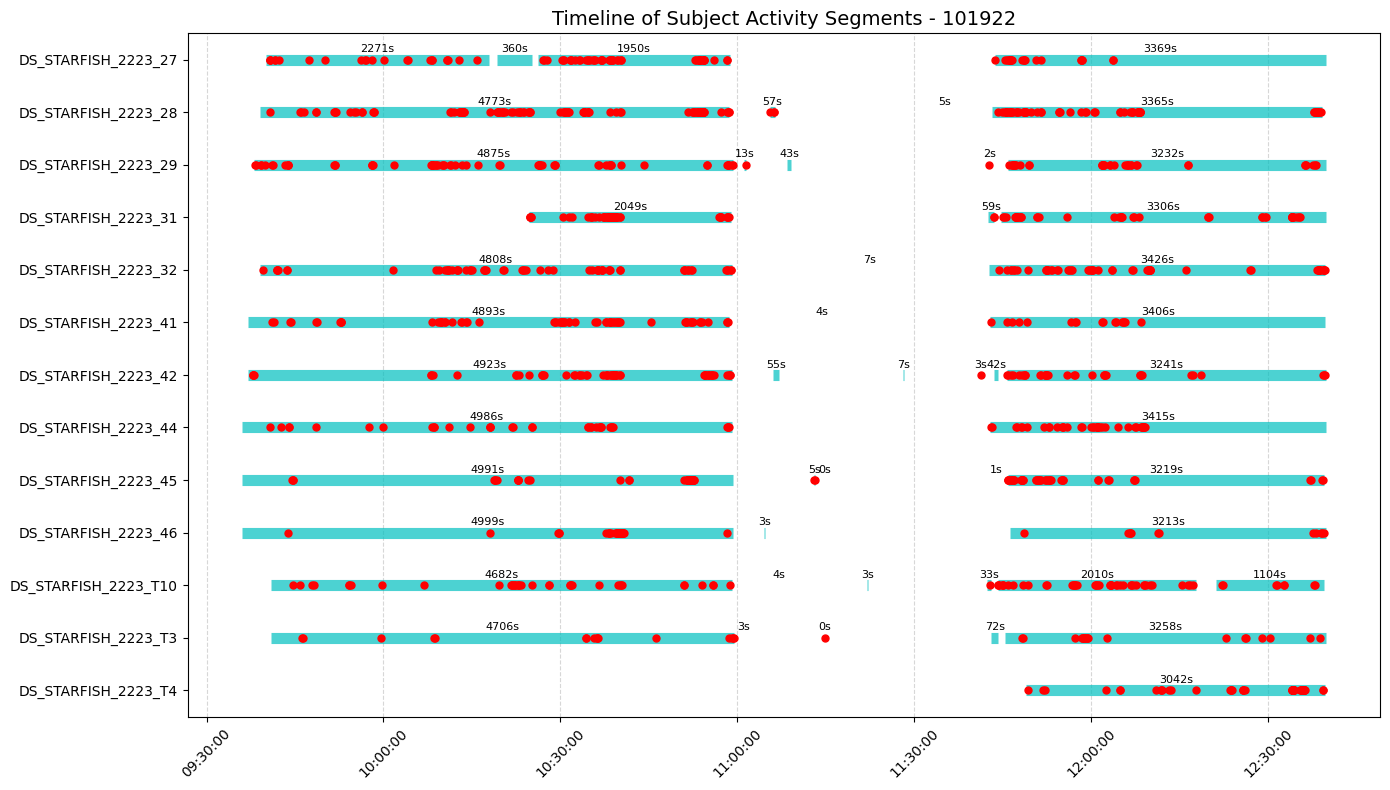

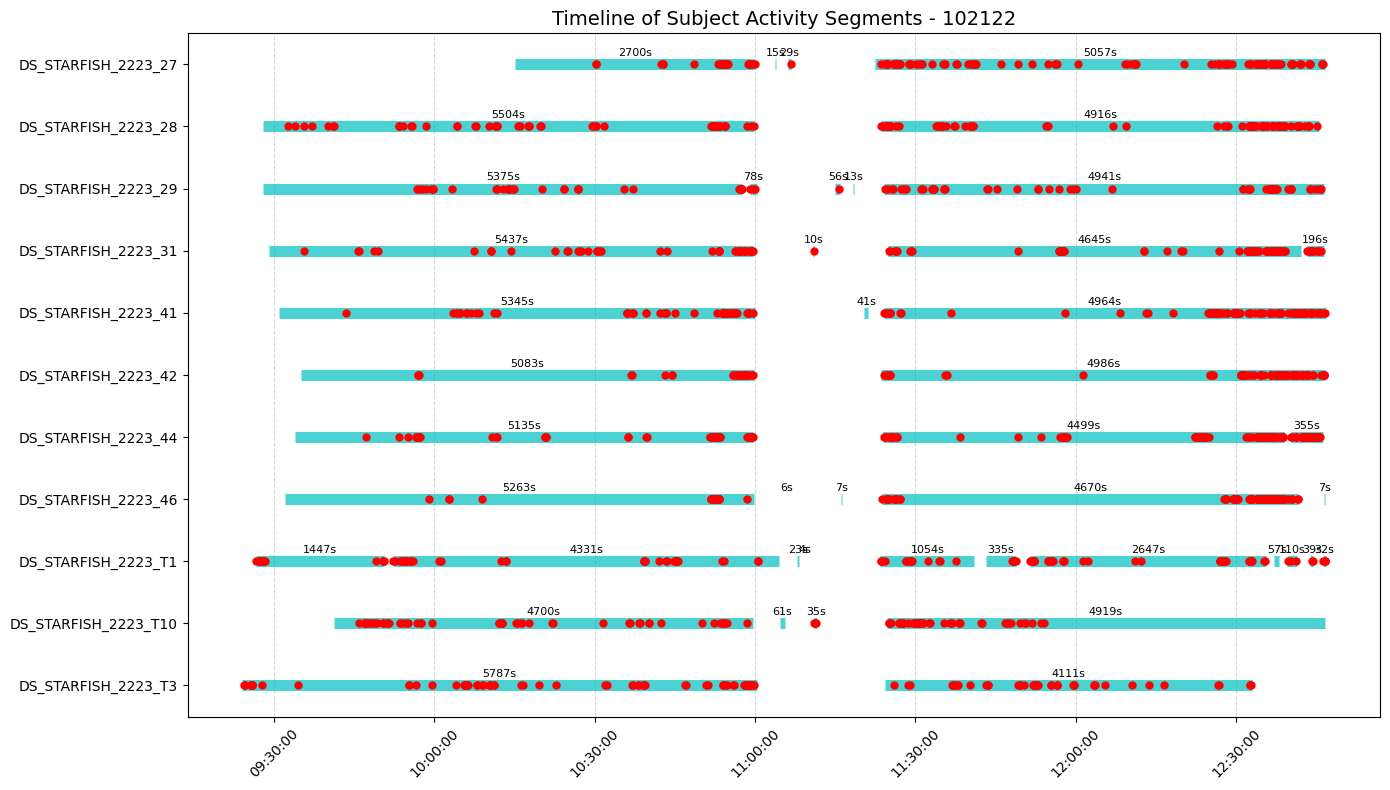

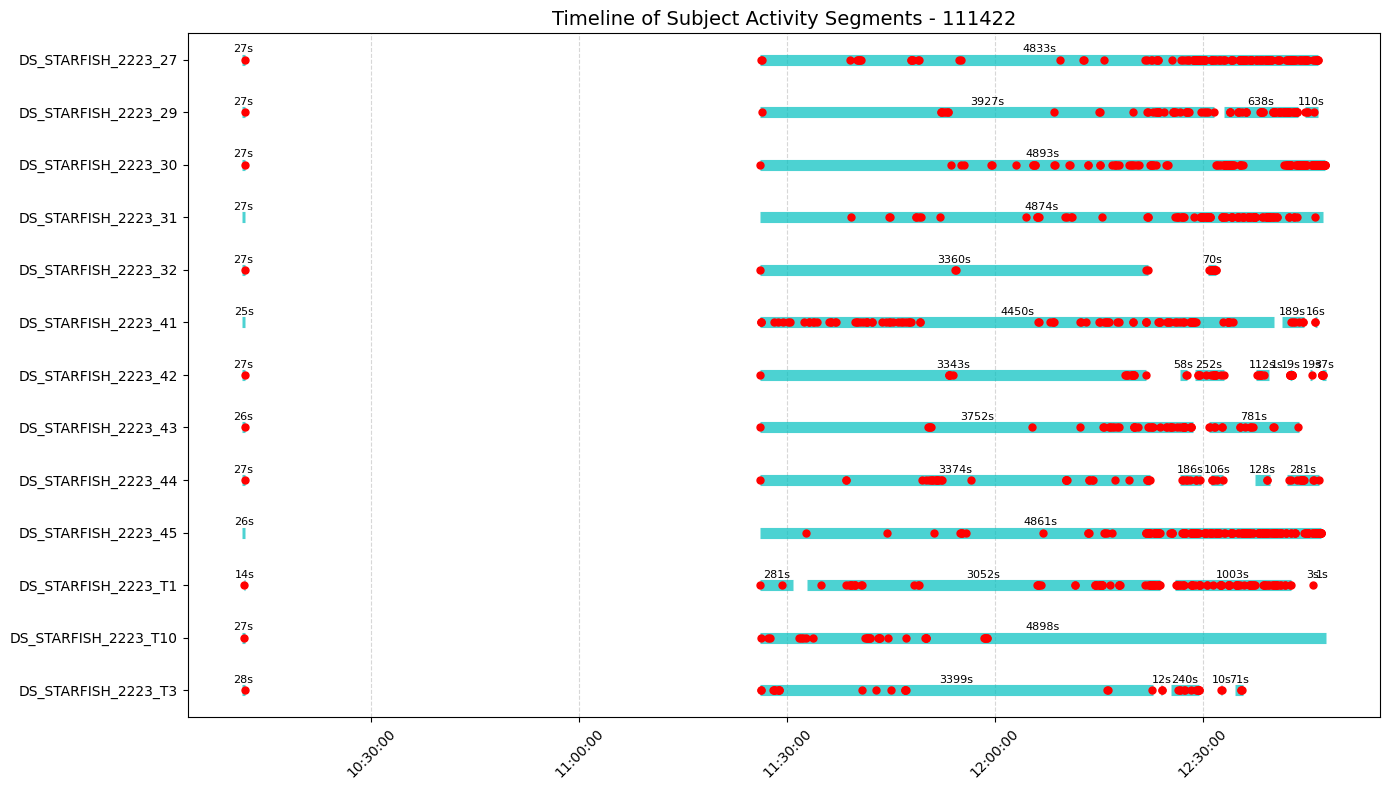

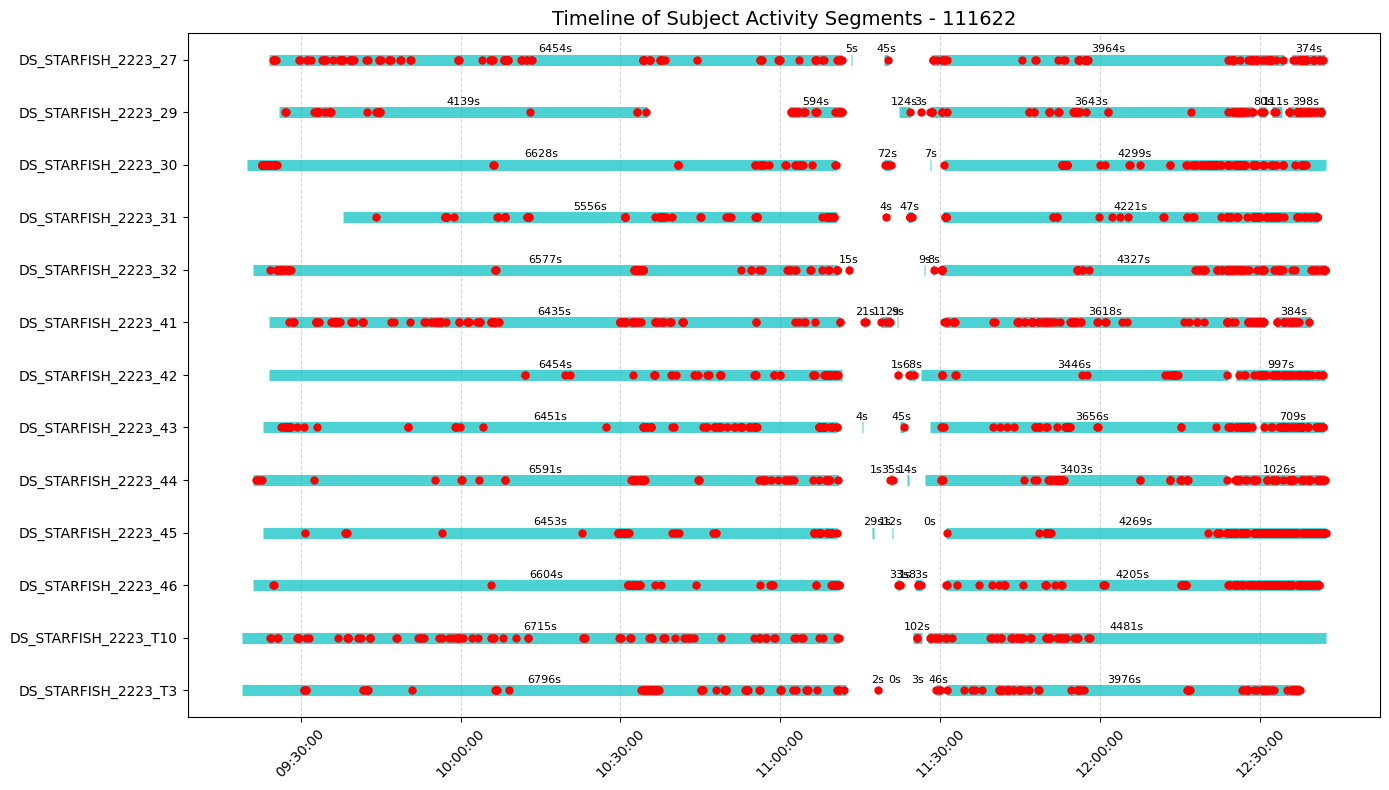

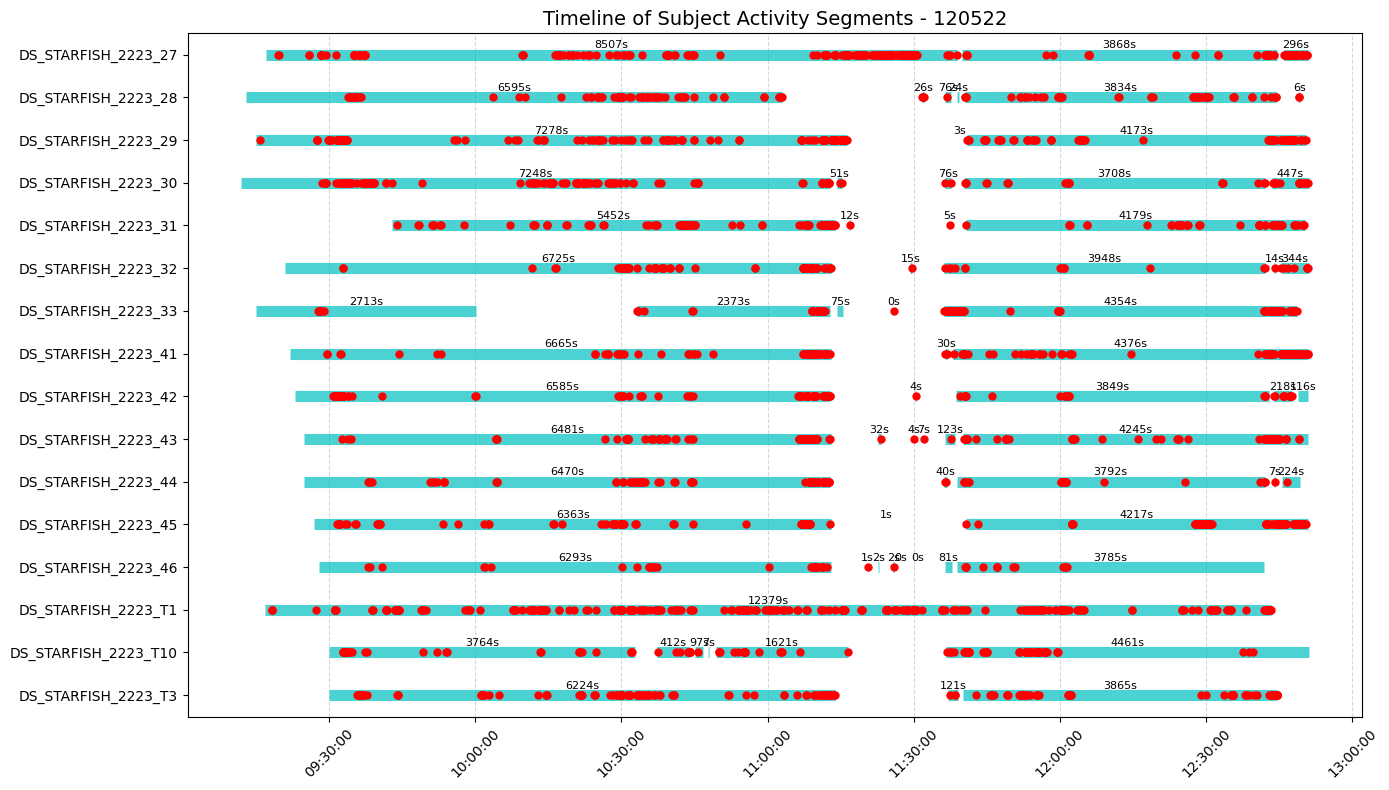

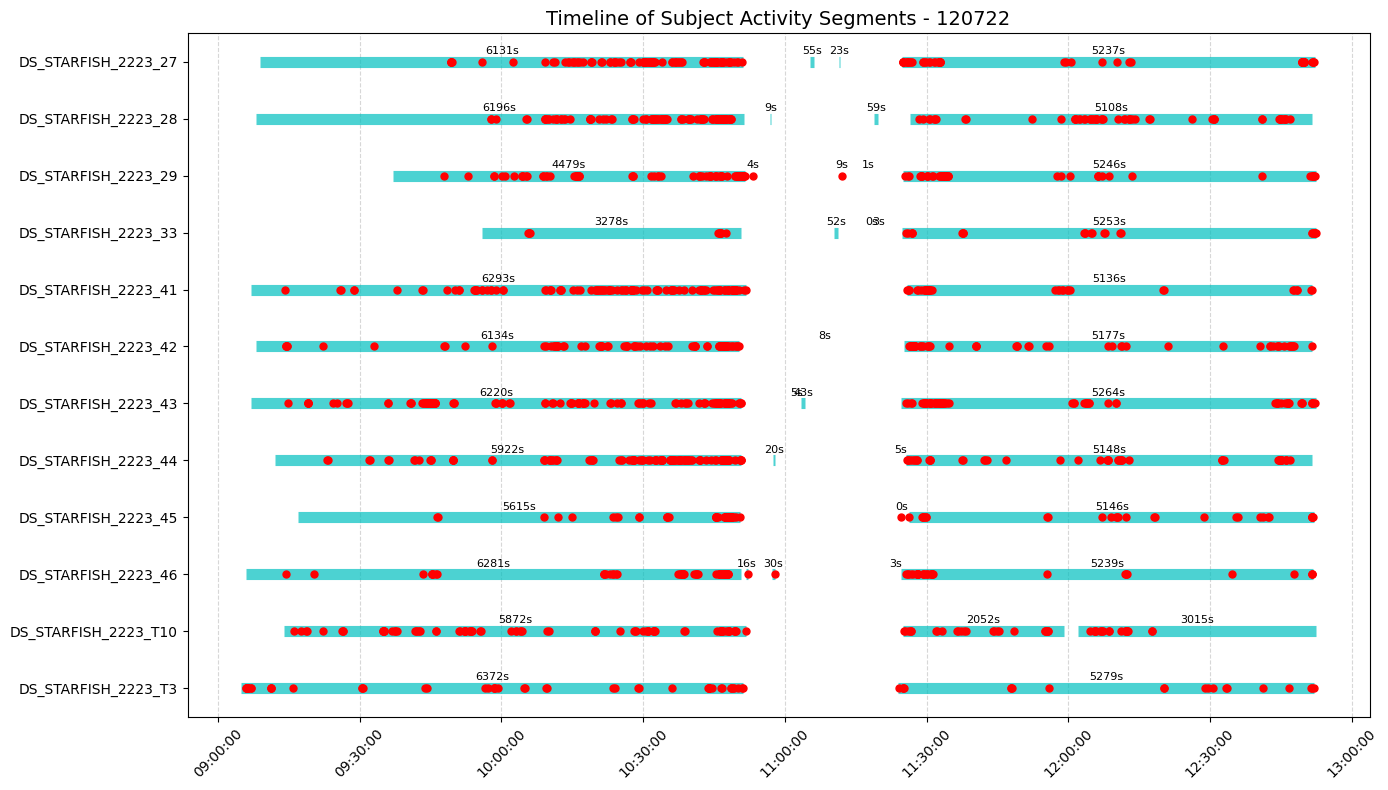

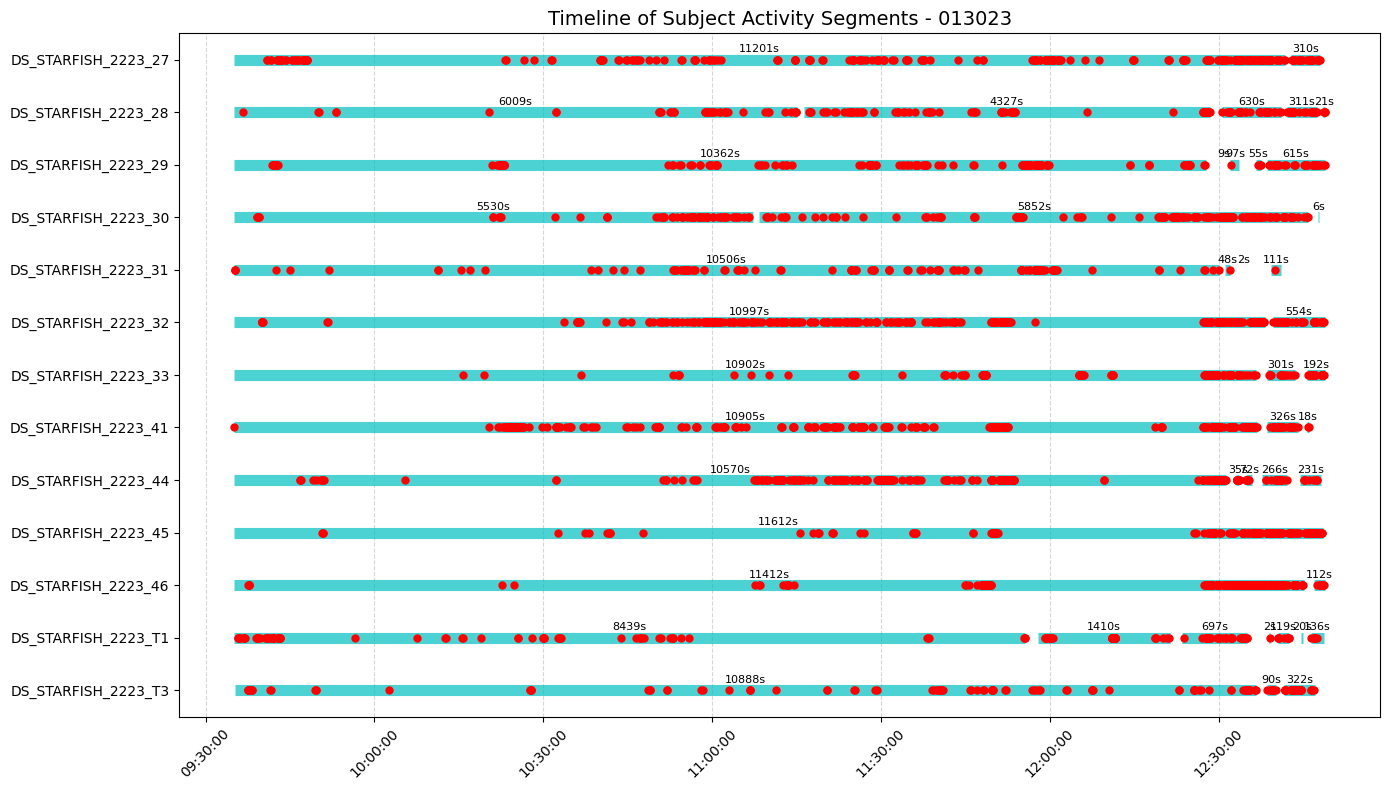

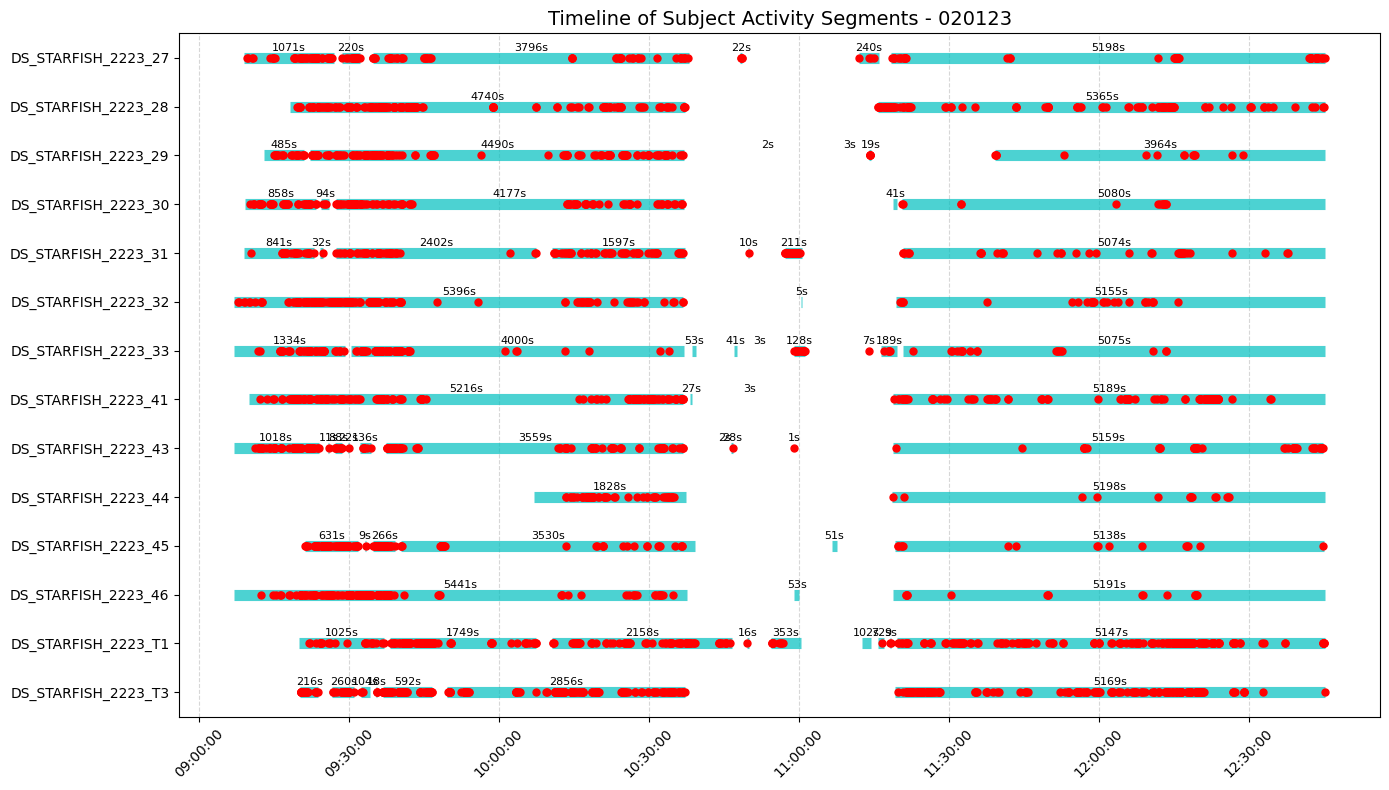

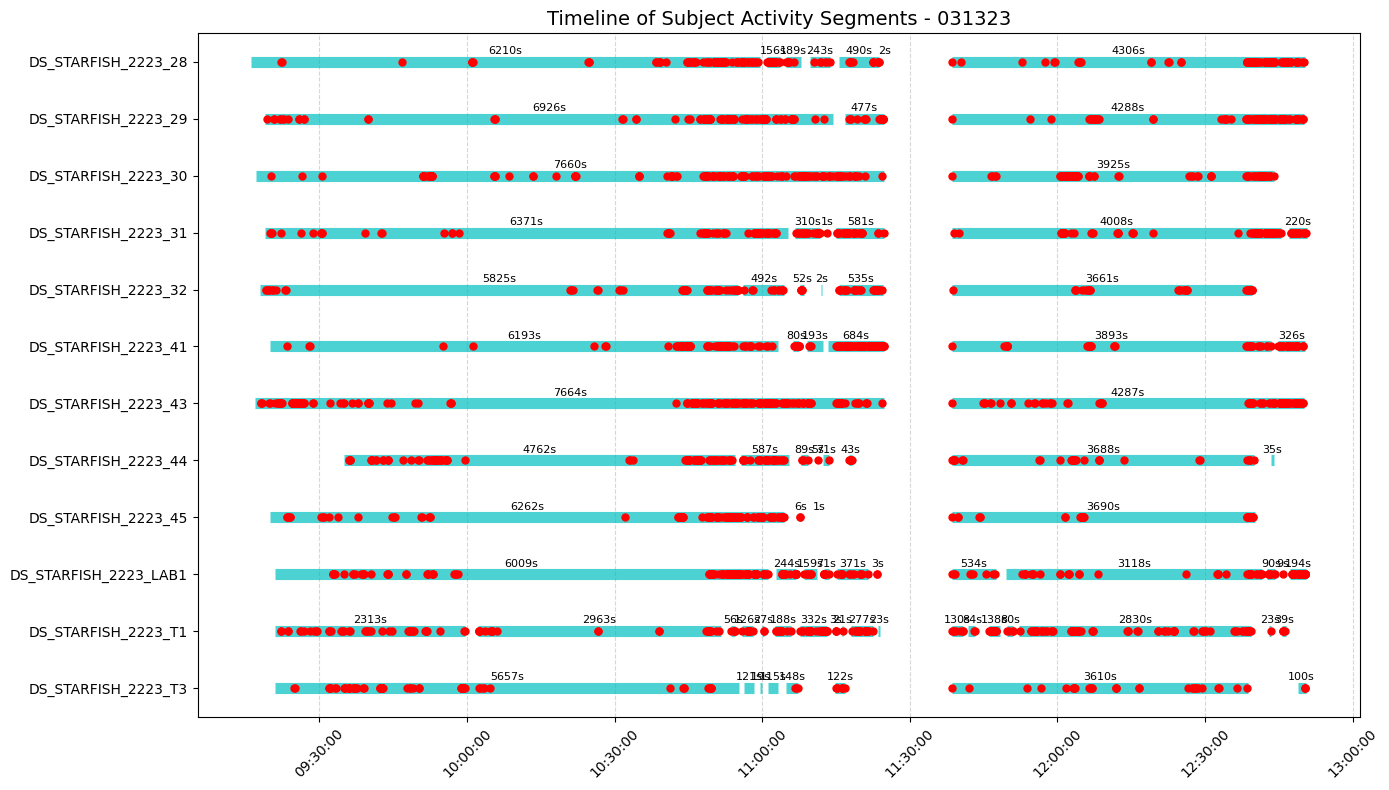

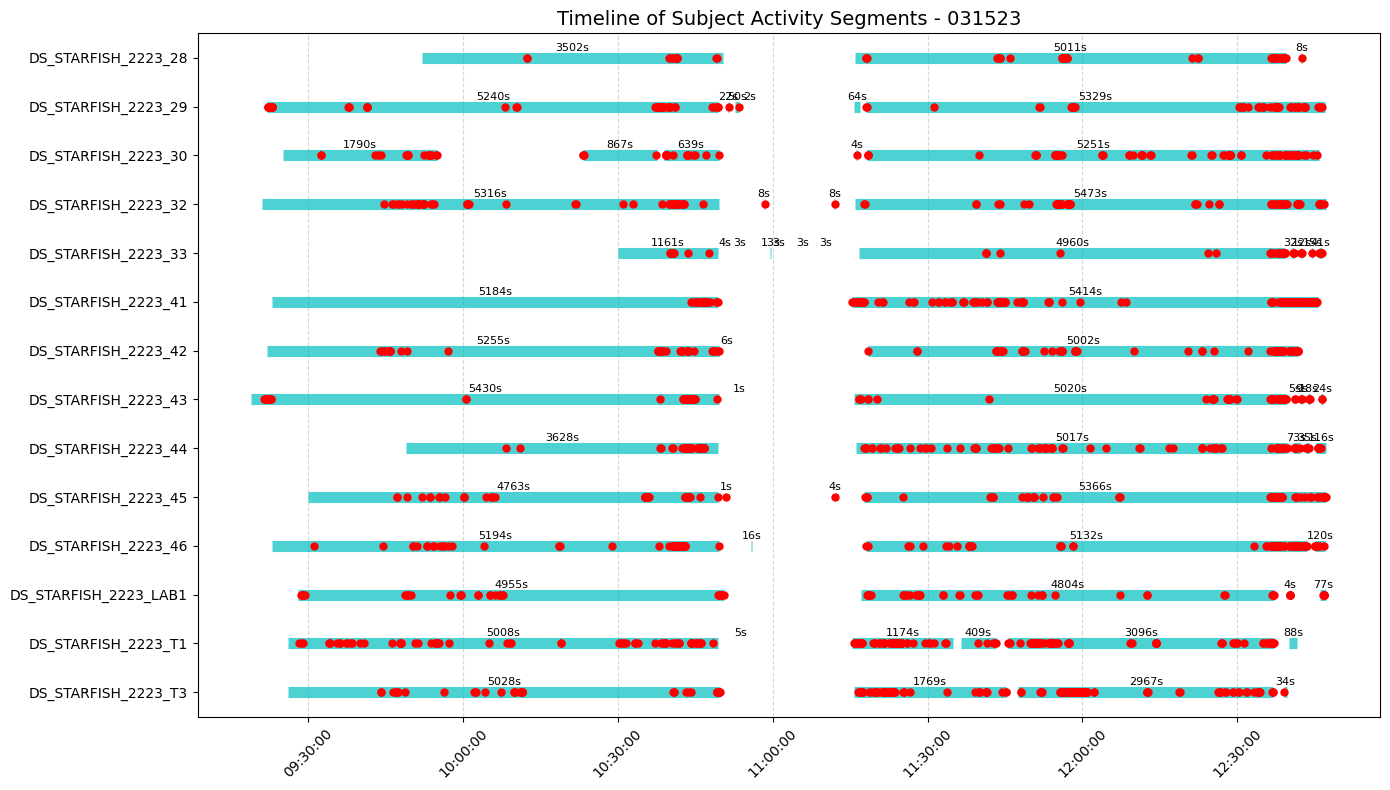

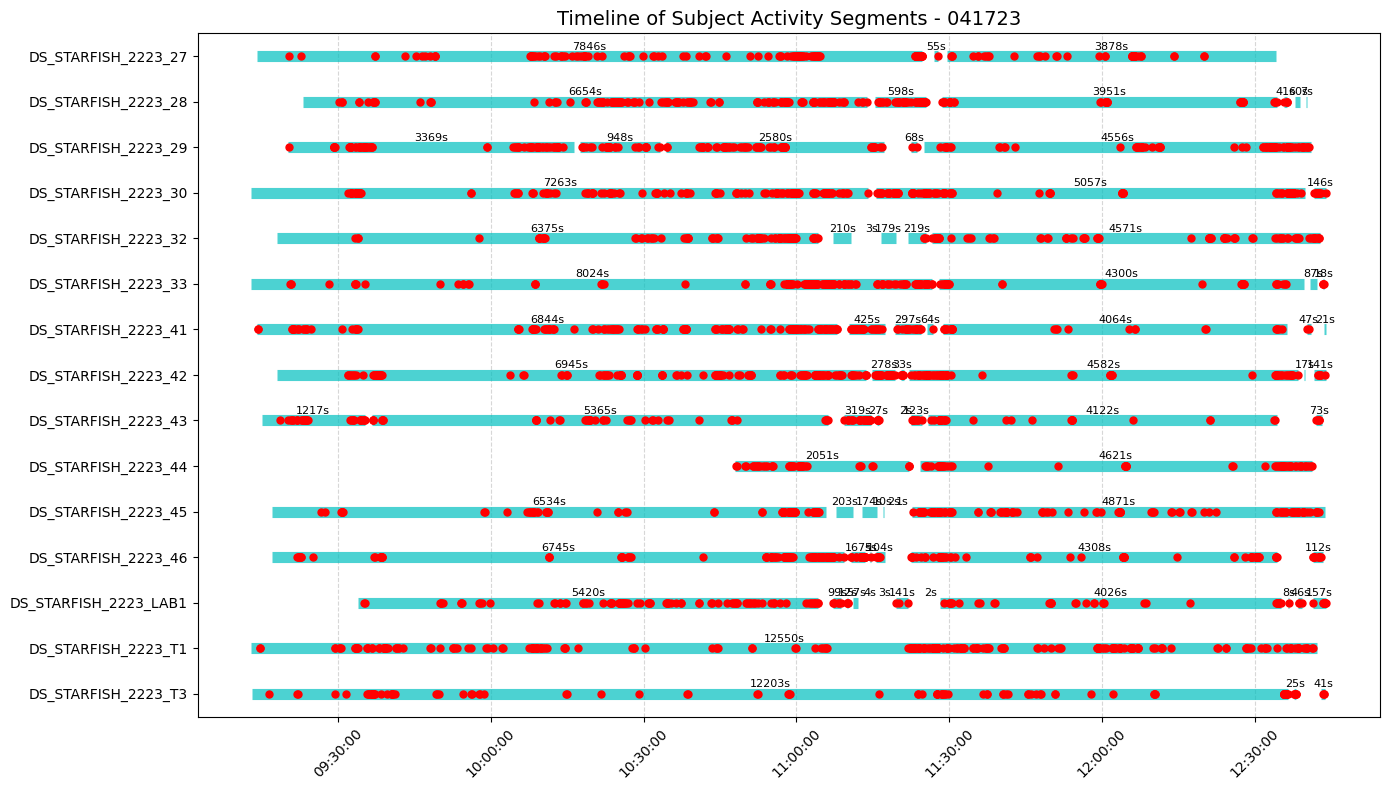

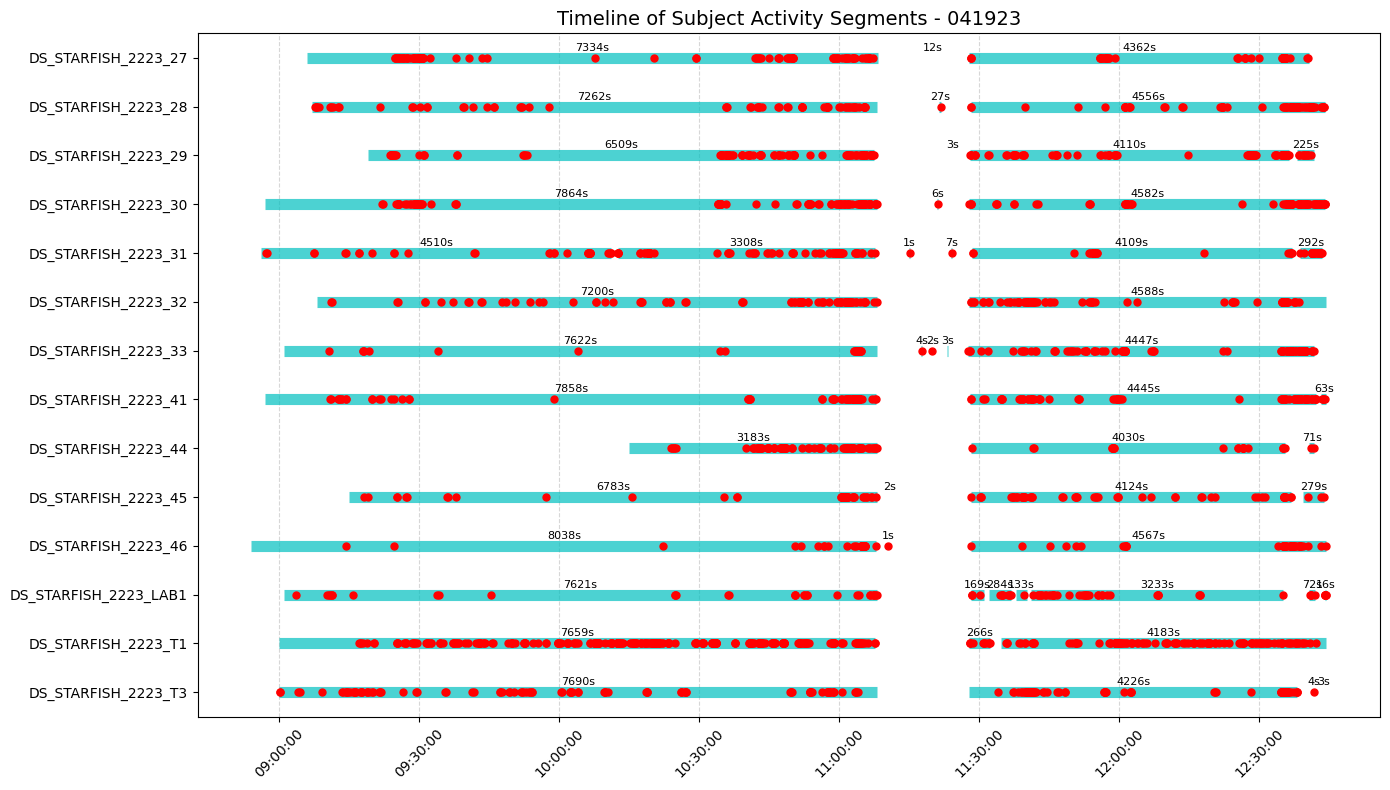

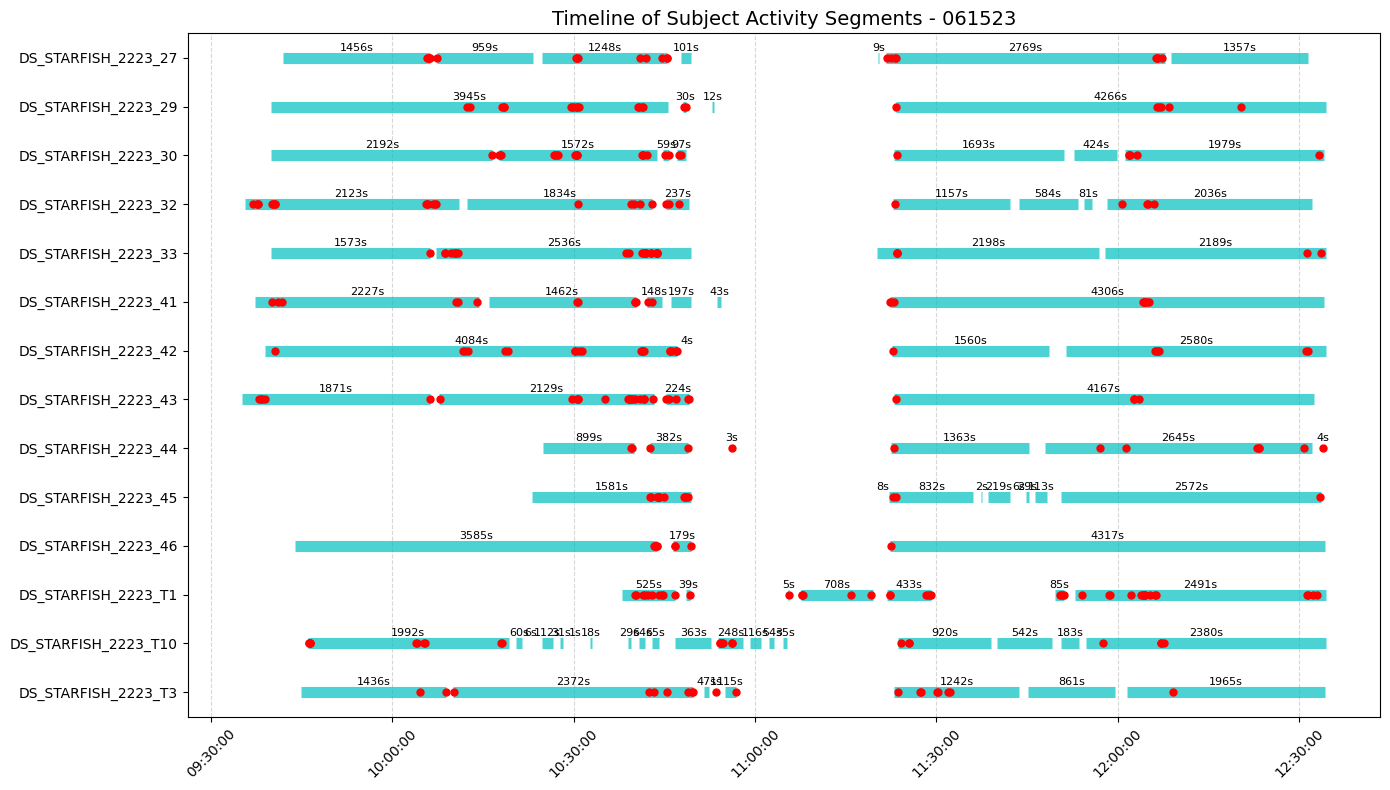

In [ ]:
# Plot the timeline of subject activity segments
# Rewirte two functions here because the conflict occurs with the previous ones
def find_inaccurate_data(group, threshold=1.5):
    group = group.sort_values("Formatted_TIME")
    x1, x2 = group["KC_X"], group["KC_X"].shift(-1)
    y1, y2 = group["KC_Y"], group["KC_Y"].shift(-1)
    distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    inaccurate_indices = distance > threshold
    inaccurate_points = group.loc[inaccurate_indices, ["Formatted_TIME", "KC_X", "KC_Y"]]
    return inaccurate_points

def segment_time_periods(subject_data, threshold=pd.Timedelta(seconds=30)):
    if subject_data.empty:
        return []
    
    subject_data = subject_data.sort_values("Formatted_TIME")
    
    segments = []
    start_time = subject_data["Formatted_TIME"].iloc[0]
    prev_time = start_time
    
    for idx, row in subject_data.iterrows():
        current_time = row["Formatted_TIME"]
        time_diff = current_time - prev_time
        
        # If gap is larger than threshold, create a new segment
        if time_diff > threshold:
            segments.append((start_time, prev_time))
            start_time = current_time
        
        prev_time = current_time
    
    # Add the last segment
    segments.append((start_time, prev_time))
    
    return segments

for file_date_str in file_date:
    file_name = f"co_{file_date_str}_resampled.csv"
    file_path = f"data_resample/sec/csv/{file_name}"
    sec_data = pd.read_csv(file_path, header=None, names=["SUBJECTID", "KC_X", "KC_Y", "Formatted_TIME"])
    sec_data["Formatted_TIME"] = pd.to_datetime(sec_data["Formatted_TIME"], format='%H:%M:%S', errors='coerce')
    subject_ids = sec_data["SUBJECTID"].unique()
    
    # Using functions
    subject_segments = {
        subject_id: segment_time_periods(sec_data[sec_data["SUBJECTID"] == subject_id]) 
        for subject_id in subject_ids
    }
    
    inaccurate_data = {
        subject_id: find_inaccurate_data(sec_data[sec_data["SUBJECTID"] == subject_id]) 
        for subject_id in subject_ids
    }
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    for i, (subject_id, segments) in enumerate(subject_segments.items()):
        y_position = len(subject_ids) - i  # Vertical position for this subject
        
        for start_time, end_time in segments:
            ax.hlines(y_position, start_time, end_time, color='c', linewidth=8, alpha=0.7)
            
            duration = (end_time - start_time).total_seconds()
            
            # Add duration label
            mid_point = start_time + (end_time - start_time) / 2
            ax.text(mid_point, y_position + 0.1, f"{int(duration)}s",
                   ha='center', va='bottom', fontsize=8)
    
    # Plot inaccurate points
    for subject_id, inaccurate_points in inaccurate_data.items():
        if not inaccurate_points.empty:
            y_position = len(subject_ids) - list(subject_ids).index(subject_id)
            
            for _, point in inaccurate_points.iterrows():
                ax.scatter(point["Formatted_TIME"], y_position,
                          marker='.', color='red', s=100, zorder=10)
    
    ax.set_yticks(range(1, len(subject_ids) + 1))
    ax.set_yticklabels(subject_ids[::-1])  # Reverse order to match the plot
    ax.set_ylim(0.5, len(subject_ids) + 0.5)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.xticks(rotation=45)
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)
    
    plt.title(f'Timeline of Subject Activity Segments - {file_date_str}', fontsize=14)
    plt.tight_layout()
    plt.show()